In [55]:
from keras.layers import LSTM, Dense, Dropout, Embedding, Masking, Bidirectional,Flatten
from keras.layers import SpatialDropout1D, SpatialDropout2D, SpatialDropout3D, Bidirectional
from keras.layers import Conv1D, BatchNormalization, Conv2D, MaxPooling2D, MaxPooling1D, Flatten, Dropout
from python_speech_features import mfcc
from python_speech_features import logfbank
from keras.models import Sequential, load_model
from keras.optimizers import Adam
from keras.utils import plot_model
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
from sklearn.preprocessing import LabelEncoder,normalize
from matplotlib import pyplot
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import scipy.io.wavfile as wav
import numpy as np
import keras
import csv
import os
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import time
import tensorflow as tf
import librosa
import soundfile as sf
import pickle


import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import librosa
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from src.preprocess import transform_to_data_loader
# from src.train import train_model
from src.preprocess_utils import create_binary_labels

from torchinfo import summary
from torchaudio.transforms import MFCC

In [20]:
CLASSES = ["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go", "unknown"]
n_classes = len(CLASSES)

In [109]:
from src.preprocess_utils import convert_to_array
from src.data_loader import load_data


# X, y = np.load("augmented_data.npy"), np.load("augmented_labels.npy")
train_ds, val_ds = load_data()
X, y = convert_to_array(train_ds)
X2, y2 = convert_to_array(val_ds)
X = np.concatenate((X, X2), axis=0)
y = np.concatenate((y, y2), axis=0)

X = X[y != 10]
y = y[y != 10]

y_encoded = np.zeros((y.size, y.max() + 1))
y_encoded[np.arange(y.size), y] = 1
# y_encoded = np.expand_dims(create_binary_labels(y), 1)

transform = MFCC(sample_rate=16000, n_mfcc=10, melkwargs={"n_fft": 400, "hop_length": 40, "n_mels": 20, "center": False})
X_tensor = torch.from_numpy(X)

indices = [i for i in range(0, X_tensor.shape[0], 5000)]
indices.append(X_tensor.shape[0])

X_transformed = transform(X_tensor[indices[0]:indices[1]])
for i in range(1, len(indices)-1):
    X_transformed = np.concatenate((X_transformed, transform(X_tensor[indices[i]:indices[i+1]]).numpy()), 0)

#Normalizing the MFCC values.
scaler = MinMaxScaler(feature_range=(0,1))
X_normalized = scaler.fit_transform(X_transformed.reshape(-1, X_transformed.shape[-1])).reshape(X_transformed.shape)

X_train, X_valid, Y_train, Y_valid =  train_test_split(X_normalized, y_encoded, test_size=0.3, random_state=42, shuffle=True)
X_valid, X_test, Y_valid, Y_test =  train_test_split(X_valid, Y_valid, test_size=0.33, random_state=42, shuffle=True)

Found 64721 files belonging to 30 classes.
Using 51777 files for training.
Using 12944 files for validation.


In [107]:
X_main = X_normalized[y != 10]
y_main = y[y != 10]

X_main.shape

(23682, 10, 391)

In [110]:
X_train.shape, Y_train.shape, X_valid.shape, Y_valid.shape, X_test.shape, Y_test.shape
# Y_test

((16577, 10, 391),
 (16577, 10),
 (4760, 10, 391),
 (4760, 10),
 (2345, 10, 391),
 (2345, 10))

In [44]:
def update_seed(new_random_seed):
    np.random.seed(new_random_seed)
    tf.keras.utils.set_random_seed(new_random_seed)

In [57]:
def train_model(model, train_data, val_data, test_data, lr, epochs, batch, path='checkpoint'):
    callbacks = [
        EarlyStopping(monitor='val_loss', min_delta=0.01, patience=5, mode = 'min')
    ]
    m = model()
    m.compile(optimizer=Adam(amsgrad=True, learning_rate=lr),loss='categorical_crossentropy',metrics=['accuracy'])
    history = m.fit(train_data[0], train_data[1],
                    epochs=epochs,
                    callbacks=callbacks,
                    batch_size=batch,
                    validation_data=val_data,
                    verbose=1,
                    shuffle=True)

    datetime = time.strftime("%Y%m%d-%H%M%S")
    m.save(os.path.join(path, 'model_' + datetime))

    #plotting the loss
    history = m.history
    pyplot.plot(history.history['loss'])
    pyplot.plot(history.history["val_loss"])
    pyplot.title("train and validation loss")
    pyplot.ylabel("value")
    pyplot.xlabel("epoch")
    pyplot.legend(['train','validation'])
    plt.show()

    #plotting the loss
    pyplot.plot(history.history['accuracy'])
    pyplot.plot(history.history["val_accuracy"])
    pyplot.title("train and validation accuracy")
    pyplot.ylabel("accuracy value")
    pyplot.xlabel("epoch")
    pyplot.legend(['train','validation'])
    plt.show()

    y_prediction = m.predict(test_data[0])
    y_prediction = np.argmax(y_prediction, axis = 1)
    y_test_single_column=np.argmax(test_data[1], axis=1)
    result = confusion_matrix(y_test_single_column, y_prediction , normalize='pred')
    plt.figure(figsize=(20,20))
    labels = CLASSES
    sns.heatmap(result, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion matrix on test data')
    plt.show()
    
    result = confusion_matrix(y_test_single_column, y_prediction)
    plt.figure(figsize=(20,20))
    labels = CLASSES
    sns.heatmap(result, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion matrix on test data')
    plt.show()

    
    acc_train = accuracy_score(np.argmax(train_data[1], axis=1), np.argmax(m.predict(train_data[0]), axis = 1))
    print(f"Accuracy score on train dataset: {acc_train}")
    acc_val = accuracy_score(np.argmax(val_data[1], axis=1), np.argmax(m.predict(val_data[0]), axis = 1))
    print(f"Accuracy score on validation dataset: {acc_val}")
    acc_test = accuracy_score(y_test_single_column, y_prediction)
    print(f"Accuracy score on test dataset: {acc_test}")

    return [acc_train, acc_val, acc_test]

In [46]:
def repeat_train(model, train_data, val_data, test_data, lr, epochs, batch, seeds, path='checkpoint'):
    accuracy = []
    for seed in seeds:
        print(f"Training with seed {seed}")
        p = os.path.join(path, str(seed))
        if not os.path.exists(path):
            os.mkdir(path)
        if not os.path.exists(p):
            os.mkdir(p)
        update_seed(seed)
        acc = train_model(model, train_data, val_data, test_data, lr, epochs, batch, path=p)
        accuracy.append(acc)
    with open(os.path.join(path, 'accuracy'), 'wb') as f:
        pickle.dump(accuracy, f)

    

In [116]:
def model1():
    model = Sequential()
    model.add(LSTM(200,input_shape=(10,391),return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(Y_test.shape[1], activation='softmax'))
    return model

def model8():
    model = Sequential()
    model.add(Bidirectional(LSTM(256,return_sequences=True, input_shape=(10,391))))
    model.add(BatchNormalization())
    model.add(Bidirectional(LSTM(128,return_sequences=False, input_shape=(10,391))))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(n_classes-1, activation='softmax'))
    
    return model

In [ ]:
X_train.shape, np.expand_dims(X_train, 1).shape, 

((16577, 10, 391), (16577, 1, 10, 391))

Training with seed 0
Epoch 1/100
519/519 [==============================] - 90s 163ms/step - loss: 2.3363 - accuracy: 0.1014 - val_loss: 2.3028 - val_accuracy: 0.0931
Epoch 2/100
519/519 [==============================] - 121s 233ms/step - loss: 2.3037 - accuracy: 0.0991 - val_loss: 2.3030 - val_accuracy: 0.0931
Epoch 3/100
519/519 [==============================] - 121s 233ms/step - loss: 2.3031 - accuracy: 0.1000 - val_loss: 2.3030 - val_accuracy: 0.1002
Epoch 4/100
519/519 [==============================] - 121s 233ms/step - loss: 2.3029 - accuracy: 0.1001 - val_loss: 2.3031 - val_accuracy: 0.0954
Epoch 5/100
519/519 [==============================] - 121s 232ms/step - loss: 2.3029 - accuracy: 0.1011 - val_loss: 2.3032 - val_accuracy: 0.0954
Epoch 6/100
519/519 [==============================] - 121s 232ms/step - loss: 2.3029 - accuracy: 0.1013 - val_loss: 2.3030 - val_accuracy: 0.0954


INFO:tensorflow:Assets written to: checkpoint_lstm_one_layer\0\model_20240504-190211\assets


INFO:tensorflow:Assets written to: checkpoint_lstm_one_layer\0\model_20240504-190211\assets


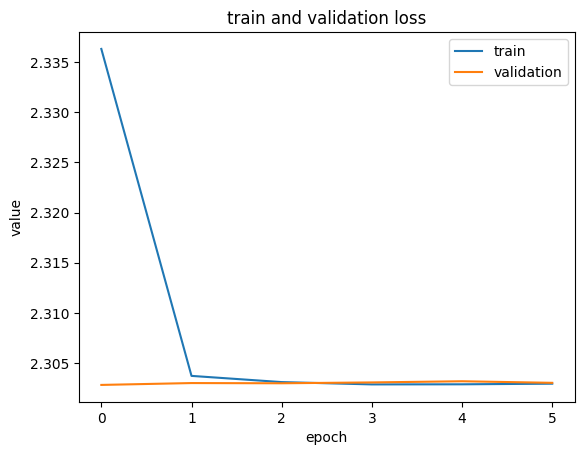

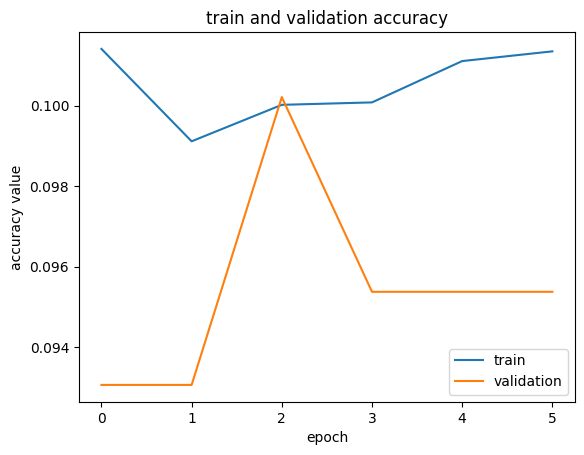

74/74 [==============================] - 7s 89ms/step


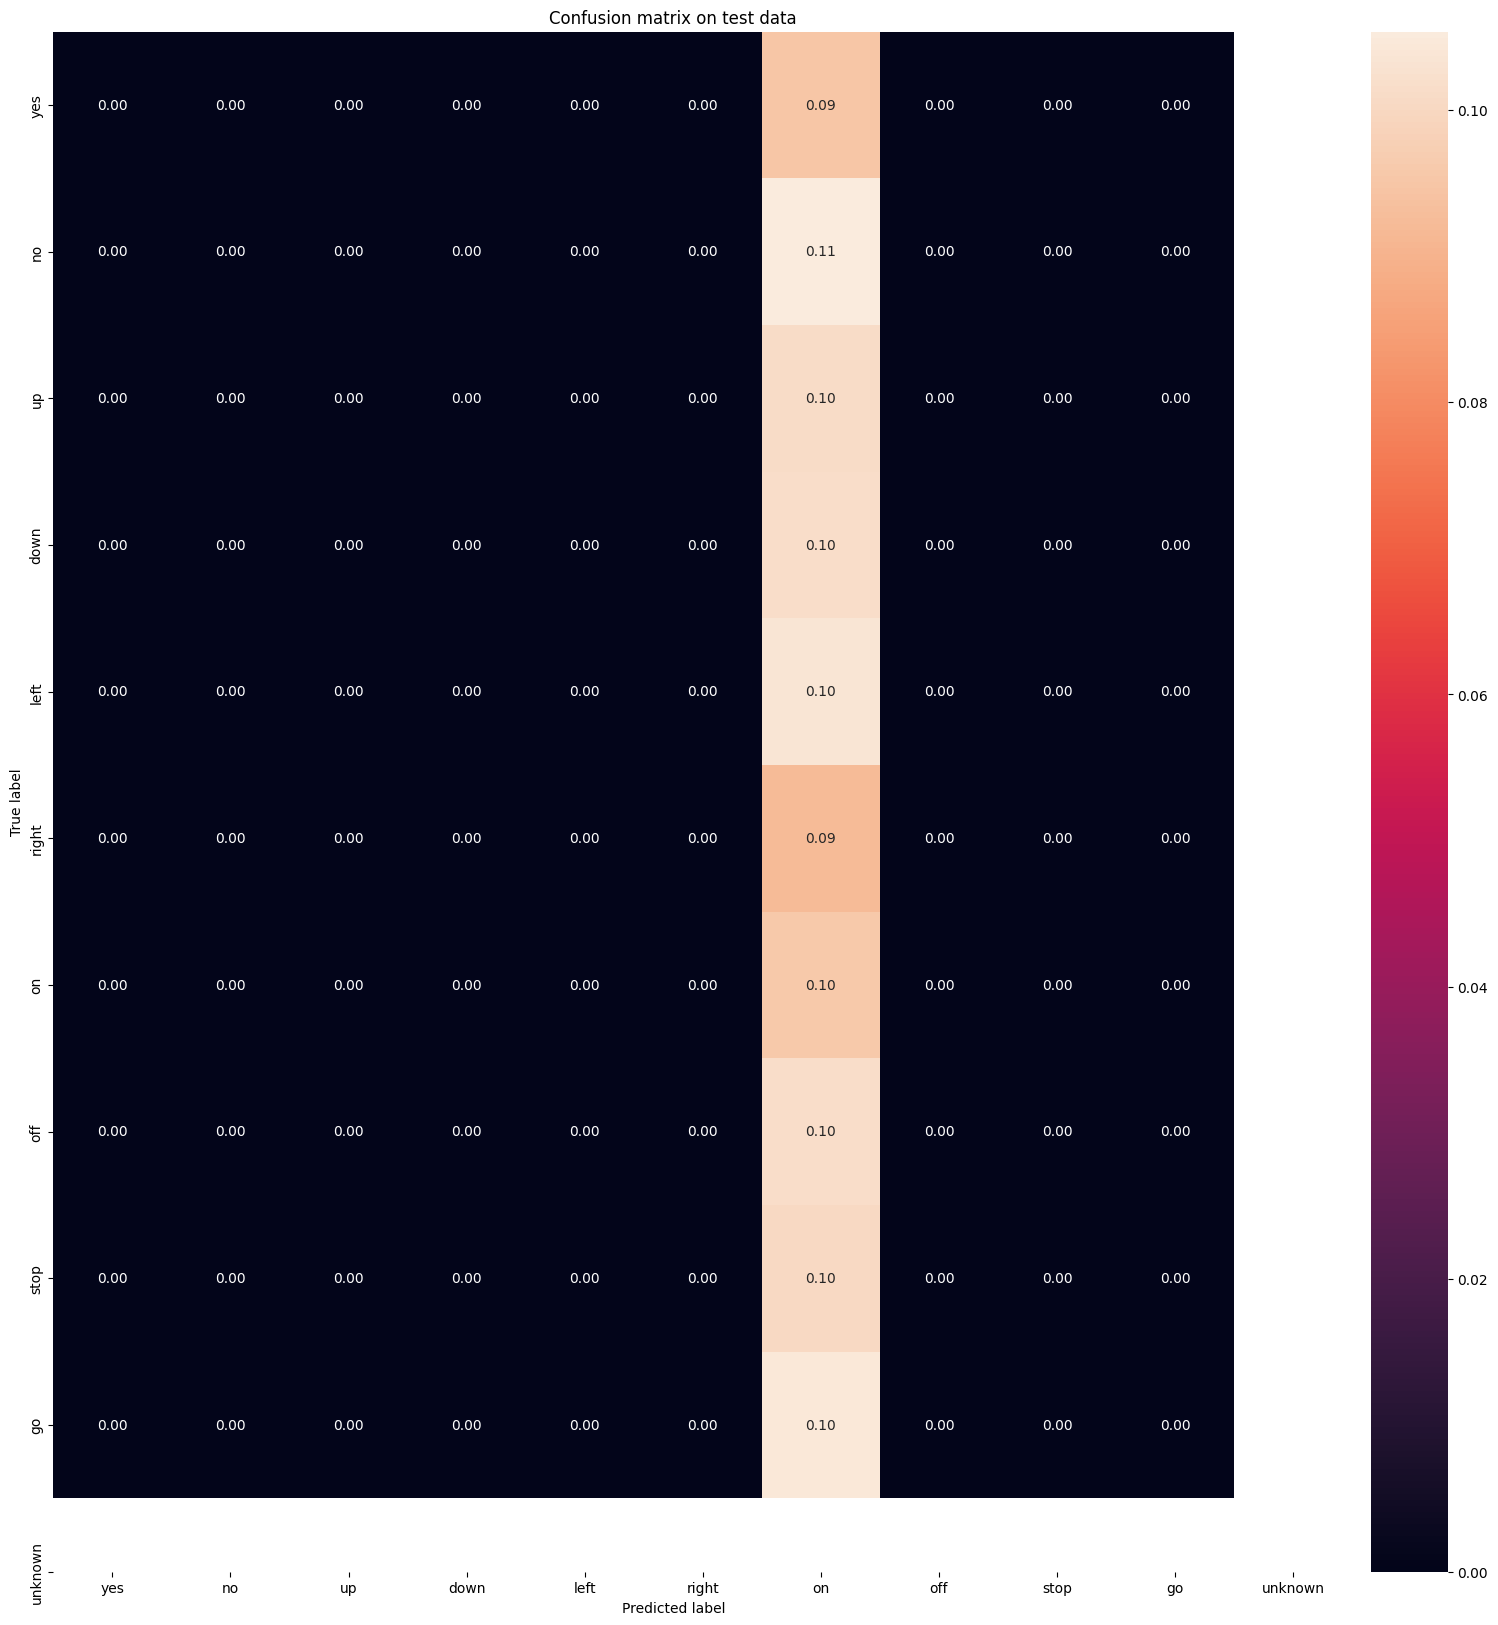

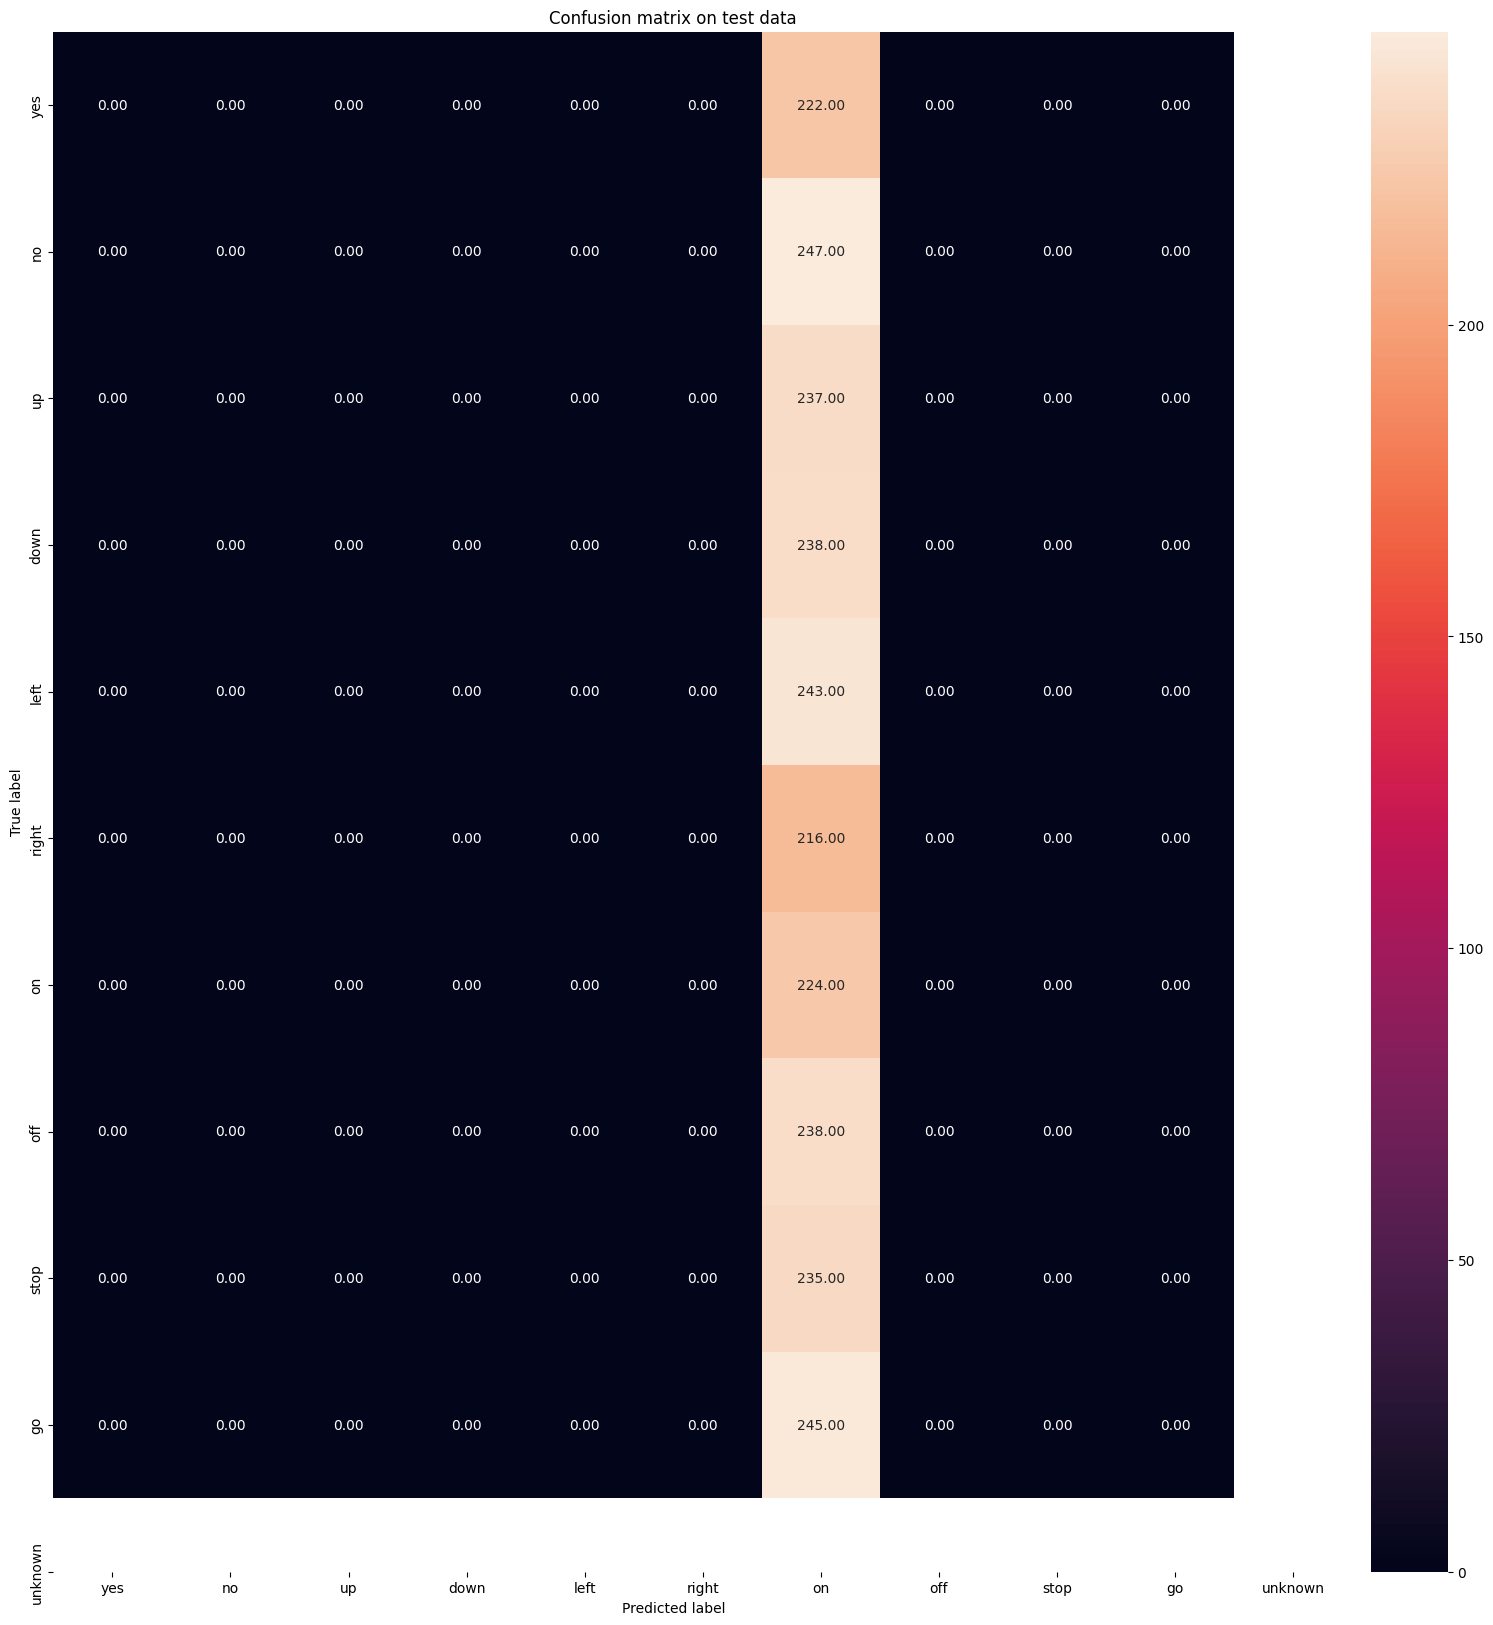

519/519 [==============================] - 43s 82ms/step
Accuracy score on train dataset: 0.10188815829160885
149/149 [==============================] - 11s 74ms/step
Accuracy score on validation dataset: 0.0953781512605042
Accuracy score on test dataset: 0.0955223880597015
Training with seed 10
Epoch 1/100
204/519 [==========>...................] - ETA: 51s - loss: 2.3768 - accuracy: 0.1000

KeyboardInterrupt: 

In [117]:
repeat_train(model8, (X_train, Y_train), (X_valid, Y_valid), (X_test, Y_test), lr=0.001, epochs=100, batch=32,
             seeds=[0, 10, 20, 30, 40], path='checkpoint_lstm_one_layer')

# repeat_train(model8, (np.expand_dims(X_train, 1), np.expand_dims(Y_train, 1)), (np.expand_dims(X_valid, 1), np.expand_dims(Y_valid, 1)), (np.expand_dims(X_test, 1), np.expand_dims(Y_test, 1)), lr=0.001, epochs=100, batch=32,
#              seeds=[0, 10, 20, 30, 40], path='checkpoint_lstm_one_layer')